# Introduction
####  10가지 ML 모델로 예측 분석을 해보았습니다. train data에 대해서는 어느정도 성능을 보이나, validation data의 경우 성능이 저조하여 regression이 아닌 classification으로 접근해보려 합니다.

### Imports
Import libraries and write settings here.

In [321]:
import os
import xai
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import log_loss


mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['font.size'] = 11.5
plt.rcParams['figure.figsize'] = (14,4)

# Data Loading
Do work here

In [5]:
starbucks_feature_drop_smallreview = pd.read_excel('../starbucksDT/postprocess/Starbucks_Total_Feature_post_200713_최근지점제외_scoreA2_before_norm.xlsx')

In [6]:
starbucks_feature_smallreview = pd.read_excel('../starbucksDT/postprocess/Starbucks_Total_Feature_post_200713_최근지점만_scoreA2_before_norm.xlsx')

In [7]:
def make_class_score(df, continuous_label, cat_label='score class', split_num=10):
    sorted_df = df.sort_values(continuous_label, ascending=False).reset_index(drop=True)
    total_len = sorted_df.shape[0]
    
    def split_data(total_len, split_num):
        start, stop = 0, 0
        width, left = divmod(total_len, split_num)
        total_range = []
        for i in range(split_num):
            this_step = width
            if left > 0:
                this_step = width + 1
            left -= 1
#             print(this_step)
            stop = start + this_step
            total_range.append(np.arange(start, stop)) 
            start += this_step
        return total_range
        
    total_range = split_data(total_len, split_num)
    group_min_scores = {}
    group_score_keys = range(split_num,0,-1)
    for score_key, range_ in zip(group_score_keys,total_range):
        group_min_scores[score_key] = sorted_df.loc[range_[-1], continuous_label]
        
    def class_wrt_score(x, group_score_map):
        for k, v in group_score_map.items():
            if x >= v:
                return k
            else:
                continue
    sorted_df[cat_label] = sorted_df[continuous_label].apply(lambda x: class_wrt_score(x,group_min_scores))
    return sorted_df, group_min_scores

In [8]:
starbucks_df, ref3 = make_class_score(starbucks_feature_drop_smallreview, 'score A2', 'class3', 3)
starbucks_df, ref5 = make_class_score(starbucks_df, 'score A2', 'class5', 5)
starbucks_df, ref10 = make_class_score(starbucks_df, 'score A2', 'class10', 10)

In [194]:
split_num = 5
split_floats = {cls:ran for ran, cls in zip(reversed([x/split_num for x in range(0, split_num, 1)]), range(split_num, 0, -1))}
split_floats

{5: 0.8, 4: 0.6, 3: 0.4, 2: 0.2, 1: 0.0}

In [196]:
def split_simple(x, split_num=5):
    cls_map = {cls:ran for ran, cls in zip(reversed([x/split_num for x in range(0, split_num, 1)]), range(split_num, 0, -1))}
    for k,v in cls_map.items():
        if x >= v:
            return k
        else:
            continue

In [199]:
starbucks_df['simple_class5'] = starbucks_df['score A2'].map(lambda x:split_simple(x, 5))
starbucks_df['simple_class3'] = starbucks_df['score A2'].map(lambda x:split_simple(x, 3))

In [200]:
starbucks_df

,지점명,맥도날드 거리,관광지 리뷰수,관광지 거리,아파트 준공년월,아파트 세대수,아파트 거리,아파트 매매가 상한,주유소 거리,인근 스타벅스 거리,교통량 점수,최근접 대기업 거리,최근접 대기업 자본금,5km내 대기업 개수,score A2,class3,class5,class10,simple_class5,simple_class3
0,스타벅스 영등포신길DT점,3.284522,2981,0.578471,1683.000000,949.000000,0.330428,1.450000e+09,1.900,3.000,1.333333,1.122359,30413210000,140,0.918751,3,5,10,5,3
1,스타벅스 원주명륜DT점,1.056879,268,0.340500,4970.000000,762.000000,0.428482,2.670000e+08,0.849,2.800,1.333333,2.368095,28428930000,1,0.760444,3,5,10,4,3
2,스타벅스 경주터미널DT점,0.162548,0,0.326158,5494.497462,868.472081,0.236355,6.758046e+08,1.300,1.200,2.333333,8.809621,218500000000,0,0.753784,3,5,10,4,3
3,스타벅스 창원역DT점,0.165656,1725,1.577312,405.000000,1803.000000,1.780722,9.400000e+08,1.400,0.506,2.833333,0.051729,10231563000,8,0.731503,3,5,10,4,3
4,스타벅스 화곡DT점,2.077286,0,0.572333,6887.000000,87.000000,0.349771,5.750000e+08,1.400,1.100,4.000000,0.880115,21425800000,60,0.730365,3,5,10,4,3
5,스타벅스 김포감정DT점,0.056433,18720,0.070225,2778.000000,1074.000000,0.259838,4.300000e+08,0.975,30.000,2.666667,1.998874,119850042500,4,0.724264,3,5,10,4,3
6,스타벅스 명지강변DT점,0.860338,379,1.519889,890.000000,750.000000,0.328012,4.500000e+08,1.100,1.400,1.833333,3.207939,12000000000,8,0.720557,3,5,10,4,3
7,스타벅스 제주성산DT점,34.486777,386,0.000000,5494.497462,868.472081,0.695508,6.758046e+08,0.706,30.000,2.166667,31.264257,39478740000,0,0.720348,3,5,10,4,3
8,스타벅스 을숙도강변DT점,1.618621,379,1.352507,5914.000000,1828.000000,0.332261,4.900000e+08,0.869,1.400,2.500000,2.768673,15000000000,16,0.693199,3,5,10,4,3
9,스타벅스 제주애월DT점,13.609995,1945,1.593031,5494.497462,868.472081,0.472123,6.758046e+08,1.900,30.000,1.833333,9.019648,131783790000,0,0.688495,3,5,10,4,3


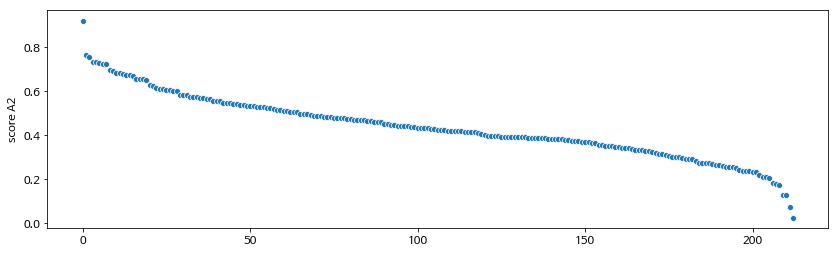

In [17]:
sns.scatterplot(starbucks_df.index, starbucks_df['score A2'])

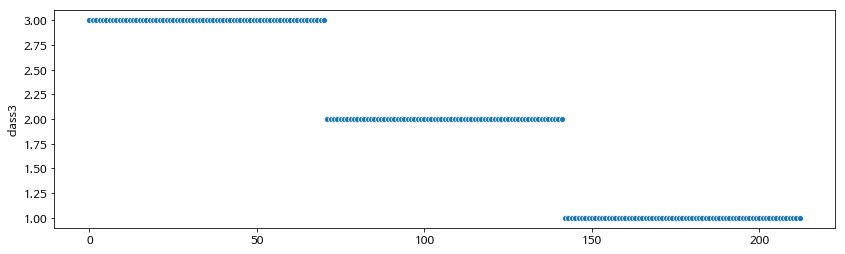

In [15]:
sns.scatterplot(starbucks_df.index, starbucks_df['class3'])

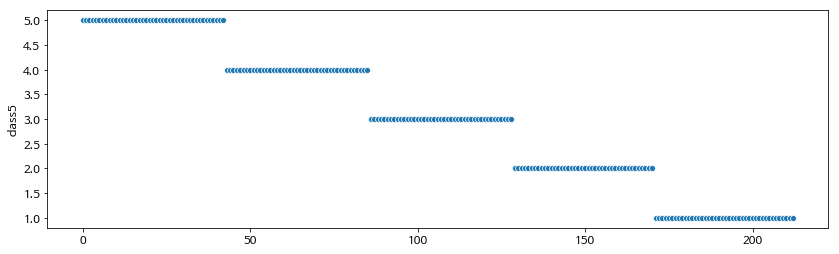

In [18]:
sns.scatterplot(starbucks_df.index, starbucks_df['class5'])

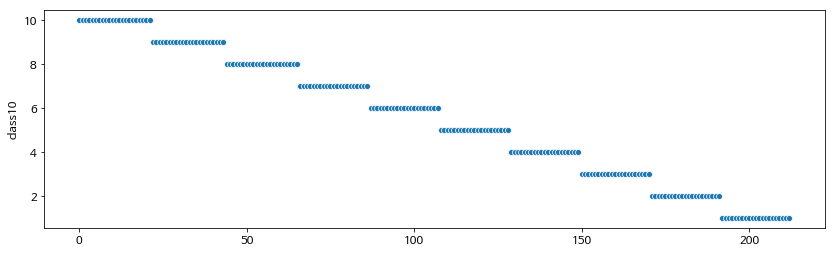

In [19]:
sns.scatterplot(starbucks_df.index, starbucks_df['class10'])

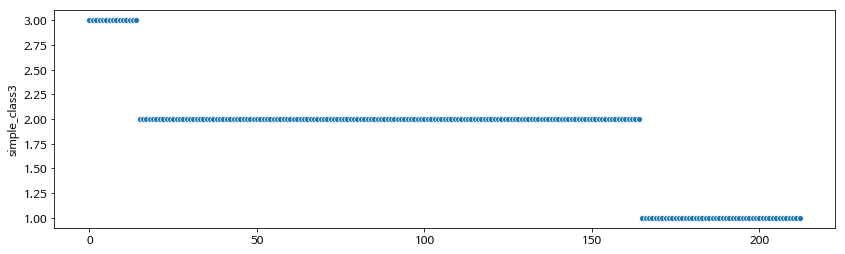

In [201]:
sns.scatterplot(starbucks_df.index, starbucks_df['simple_class3'])

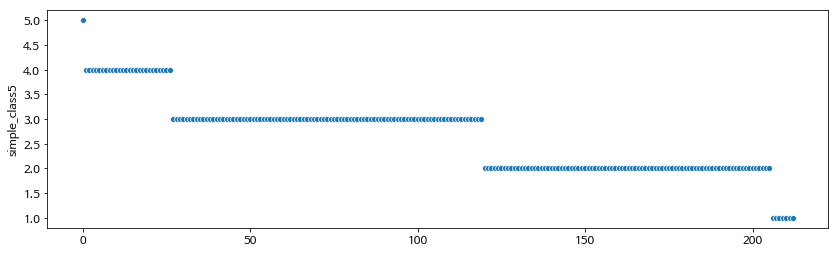

In [202]:
sns.scatterplot(starbucks_df.index, starbucks_df['simple_class5'])

In [41]:
df = starbucks_df.copy()
feature_names = starbucks_df.drop('지점명', axis=1).columns
df = df.rename(columns={x:'_'.join(x.split(' ')) for x in feature_names.values})
df = df.rename(columns={'5km내_대기업_개수':'대기업개수'})
feature_names = df.drop(['지점명', 'score_A2', 'class3', 'class5', 'class10'], axis=1).columns
feature_names

Index(['맥도날드_거리', '관광지_리뷰수', '관광지_거리', '아파트_준공년월', '아파트_세대수', '아파트_거리',
       '아파트_매매가_상한', '주유소_거리', '인근_스타벅스_거리', '교통량_점수', '최근접_대기업_거리',
       '최근접_대기업_자본금', '대기업개수'],
      dtype='object')

In [42]:
label_names = ['class3', 'class5', 'class10']

# Define function for Data Processing

In [96]:
def normalization_train_test(df_train, df_test, method='standard', except_cols=['지점명']):
    if method=='standard':
        sc = StandardScaler()
    elif method=='minmax':
        sc = MinMaxScaler()

    df_train_sc = sc.fit_transform(df_train.drop(except_cols, axis=1))
    df_test_sc = sc.transform(df_test.drop(except_cols, axis=1))

    df_train_sc = pd.DataFrame(df_train_sc, columns=df_train.drop(except_cols, axis=1).columns, index=list(df_train.index.values))
    df_test_sc = pd.DataFrame(df_test_sc, columns=df_test.drop(except_cols, axis=1).columns, index=list(df_test.index.values))

    df_train_sc[except_cols] = df_train[except_cols]
    df_test_sc[except_cols] = df_test[except_cols]
    return df_train_sc, df_test_sc

In [282]:
class Kfold(object):
    def __init__(self):
        self.models = {}
        self.train_scores = {}
        self.test_scores = {}
        self.train_errors = {}
        self.test_errors = {}
     
    @staticmethod
    def get_r2_score(y_true, y_pred):
        rss = ((y_true - y_pred) ** 2).sum()
        tss = ((y_true - y_true.mean())** 2).sum()
        rsquared = 1 - rss / tss
        return rsquared   
    
    @staticmethod
    def get_cross_val_score(model, df, train_features, label_feature, k, normalization, task):
        models = []
        train_scores = np.zeros(k)
        train_errors = []
        test_scores = np.zeros(k)
        test_errors = []
        cv = KFold(k, shuffle=True, random_state=0)
        for i, (idx_train, idx_test) in enumerate(cv.split(df)):
            df_train = df.iloc[idx_train]
            df_test = df.iloc[idx_test]
            df_train, df_test = normalization_train_test(df_train, df_test, normalization, except_cols=['지점명', label_feature])
            if model is None:
                model = sm.OLS.from_formula("score_A2 ~ " + " + ".join(feature_names2), data=df_train)
                result = model.fit()
                pred = result.predict(df_test)
                models.append(model)
            else:
                model.fit(df_train[train_features], df_train[label_feature])
                models.append(model)

            if task=='regression':
                train_score = Kfold.get_r2_score(df_train[label_feature], model.predict(df_train[train_features]))
                test_score = Kfold.get_r2_score(df_test[label_feature], model.predict(df_test[train_features]))
                train_error = mean_squared_error(df_train[label_feature], model.predict(df_train[train_features]))
                test_error = mean_squared_error(df_test[label_feature], model.predict(df_test[train_features]))
            elif task=='classification':
                train_score = accuracy_score(df_train[label_feature], model.predict(df_train[train_features]))
                test_score = accuracy_score(df_test[label_feature], model.predict(df_test[train_features]))
                train_error = mean_squared_error(df_train[label_feature], model.predict(df_train[train_features]))
                test_error = mean_squared_error(df_test[label_feature], model.predict(df_test[train_features]))
                
            train_scores[i] = train_score
            test_scores[i] = test_score
            train_errors.append(train_error)
            test_errors.append(test_error)
#             print("학습 score = {:.8f}, 검증 score = {:.8f}".format(train_score, test_score))
        print("학습 평균 score = {:.8f}, 검증 평균 score = {:.8f}".format(np.mean(train_scores), np.mean(test_score)))
        return train_scores, test_scores, models, train_errors, test_errors
    
    def cross_val(self, model_name, model, df, train_features, label_feature, k=5, normalization='minmax', task='classification'):
        values = Kfold.get_cross_val_score(model, df, train_features, label_feature, k, normalization, task)
        self.models[model_name] = values[2]
        self.train_scores[model_name] = values[0]
        self.test_scores[model_name] = values[1]
        self.train_errors[model_name] = values[3]
        self.test_errors[model_name] = values[4]
        print(f'{"*"*15} {label_feature} complete {"*"*15}\n')
        

In [283]:
kfold_3class = Kfold()
kfold_5class = Kfold()
kfold_10class = Kfold()

# Analysis/Modeling
## Decison Tree

In [284]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=12)

In [285]:
kfold_3class.cross_val('tree', tree_model, df=df, train_features=feature_names, label_feature='class3', k=10)
kfold_5class.cross_val('tree', tree_model, df=df, train_features=feature_names, label_feature='class5', k=10)
kfold_10class.cross_val('tree', tree_model, df=df, train_features=feature_names, label_feature='class10', k=10)

학습 평균 score = 0.99531250, 검증 평균 score = 0.23809524
*************** class3 complete ***************

학습 평균 score = 0.99531250, 검증 평균 score = 0.23809524
*************** class5 complete ***************

학습 평균 score = 0.96504145, 검증 평균 score = 0.14285714
*************** class10 complete ***************



## K nearest neighborhood

In [286]:
from sklearn.neighbors import KNeighborsClassifier

In [297]:
knn = KNeighborsClassifier(4)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
# define model
tree_model = DecisionTreeClassifier()

In [298]:
kfold_3class.cross_val('knn', knn, df=df, train_features=feature_names, label_feature='class3', k=10)
kfold_5class.cross_val('knn', knn, df=df, train_features=feature_names, label_feature='class5', k=10)
kfold_10class.cross_val('knn', knn, df=df, train_features=feature_names, label_feature='class10', k=10)

학습 평균 score = 0.61344350, 검증 평균 score = 0.33333333
*************** class3 complete ***************

학습 평균 score = 0.50286049, 검증 평균 score = 0.23809524
*************** class5 complete ***************

학습 평균 score = 0.39641961, 검증 평균 score = 0.09523810
*************** class10 complete ***************



## Random foreset

In [299]:
from sklearn.ensemble import RandomForestClassifier

In [308]:
forest = RandomForestClassifier(n_estimators=60, max_depth=10)

In [309]:
kfold_3class.cross_val('forest', forest, df=df, train_features=feature_names, label_feature='class3', k=10)
kfold_5class.cross_val('forest', forest, df=df, train_features=feature_names, label_feature='class5', k=10)
kfold_10class.cross_val('forest', forest, df=df, train_features=feature_names, label_feature='class10', k=10)

학습 평균 score = 1.00000000, 검증 평균 score = 0.38095238
*************** class3 complete ***************

학습 평균 score = 1.00000000, 검증 평균 score = 0.28571429
*************** class5 complete ***************

학습 평균 score = 1.00000000, 검증 평균 score = 0.14285714
*************** class10 complete ***************



In [337]:
from sklearn.ensemble import AdaBoostClassifier

In [378]:
adaboost_dtree = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=50)

In [379]:
kfold_3class.cross_val('adaboost_dtree', adaboost_dtree, df=df.copy(), train_features=feature_names, label_feature='class3', k=10)
kfold_5class.cross_val('adaboost_dtree', adaboost_dtree, df=df.copy(), train_features=feature_names, label_feature='class5', k=10)
kfold_10class.cross_val('adaboost_dtree', adaboost_dtree, df=df.copy(), train_features=feature_names, label_feature='class10', k=10)

학습 평균 score = 0.91966896, 검증 평균 score = 0.61904762
*************** class3 complete ***************

학습 평균 score = 0.80280050, 검증 평균 score = 0.38095238
*************** class5 complete ***************

학습 평균 score = 0.55980312, 검증 평균 score = 0.19047619
*************** class10 complete ***************



In [380]:
from sklearn.ensemble import GradientBoostingClassifier

In [407]:
gradboost = GradientBoostingClassifier(n_estimators=50, max_depth=2, random_state=0)

In [408]:
kfold_3class.cross_val('gradboost', gradboost, df=df.copy(), train_features=feature_names, label_feature='class3', k=10)
kfold_5class.cross_val('gradboost', gradboost, df=df.copy(), train_features=feature_names, label_feature='class5', k=10)
kfold_10class.cross_val('gradboost', gradboost, df=df.copy(), train_features=feature_names, label_feature='class10', k=10)

학습 평균 score = 0.91498418, 검증 평균 score = 0.33333333
*************** class3 complete ***************

학습 평균 score = 0.94575971, 검증 평균 score = 0.23809524
*************** class5 complete ***************

학습 평균 score = 0.97913394, 검증 평균 score = 0.09523810
*************** class10 complete ***************



In [418]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [415]:
svc_rbf_ovo = svm.SVC(kernel='rbf', gamma=1, C=, decision_function_shape='ovo')
svc_linear_ovo = svm.SVC(kernel='linear', gamma=1, C=1, decision_function_shape='ovo')
svc_poly_ovo = svm.SVC(kernel='poly', gamma=1, C=1, decision_function_shape='ovo')
svc_sigmoid_ovo = svm.SVC(kernel='sigmoid', gamma=1, C=1, decision_function_shape='ovo')

In [419]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'),
              'C':[1, 2, 3, 5, 10], 
              'gamma':[1, 2, 10], 
              'decision_function_shape' :['ovo', 'ovr']}
svc = svm.SVC()
svc_clf = GridSearchCV(svc, parameters, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=5,
                      scoring='accuracy',verbose=2, refit=True)

In [ ]:
svc_clf.fit(df[feature_names], df['class3'])
sorted(svc_clf.cv_results_.keys())

In [416]:
kfold_3class.cross_val('svc_rbf_ovo', svc_rbf_ovo, df=df.copy(), train_features=feature_names, label_feature='class3', k=10)
kfold_5class.cross_val('svc_rbf_ovo', svc_rbf_ovo, df=df.copy(), train_features=feature_names, label_feature='class5', k=10)
kfold_10class.cross_val('svc_rbf_ovo', svc_rbf_ovo, df=df.copy(), train_features=feature_names, label_feature='class10', k=10)

학습 평균 score = 0.51542594, 검증 평균 score = 0.33333333
*************** class3 complete ***************

학습 평균 score = 0.42150687, 검증 평균 score = 0.42857143
*************** class5 complete ***************

학습 평균 score = 0.30099804, 검증 평균 score = 0.04761905
*************** class10 complete ***************



In [ ]:
import autosklearn
from autosklearn.classification import AutoSklearnClassifier

In [335]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30
)
# os.makedirs('/tmp/autosklearn_cv_example_tmp', exist_ok=True)
# os.makedirs('/tmp/autosklearn_cv_example_out', exist_ok=True)
# fit() changes the data in place, but refit needs the original data. We
# therefore copy the data. In practice, one should reload the data

In [336]:
kfold_3class.cross_val('automl', automl, df=df.copy(), train_features=feature_names, label_feature='class3', k=10)
kfold_5class.cross_val('automl', automl, df=df.copy(), train_features=feature_names, label_feature='class5', k=10)
kfold_10class.cross_val('automl', automl, df=df.copy(), train_features=feature_names, label_feature='class10', k=10)

Exception ignored in: <function BackendContext.__del__ at 0x138132048>
Traceback (most recent call last):
  File "/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/autosklearn/util/backend.py", line 128, in __del__
    self.delete_directories(force=False)
  File "/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/autosklearn/util/backend.py", line 136, in delete_directories
    % self.output_directory)
ValueError: Failed to delete output dir: /tmp/autosklearn_cv_example_out because auto-sklearn did not create it. Please make sure that the specified output dir does not exist when instantiating auto-sklearn.
Process pynisher function call:
Traceback (most recent call last):
  File "/Users/dhkim/.pyenv/versions/3.7.0/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/dhkim/.pyenv/versions/3.7.0/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  F

KeyboardInterrupt: 

In [332]:
# print(automl.cv_results_)
print(automl.show_models)

<bound method AutoSklearnEstimator.show_models of AutoSklearnClassifier(output_folder='/tmp/autosklearn_cv_example_out',
                      per_run_time_limit=30, resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 5},
                      time_left_for_this_task=120,
                      tmp_folder='/tmp/autosklearn_cv_example_tmp')>


In [327]:
print(automl.sprint_statistics())

# One can use models trained during cross-validation directly to predict
# for unseen data. For this, all k models trained during k-fold
# cross-validation are considered as a single soft-voting ensemble inside
# the ensemble constructed with ensemble selection.
print('Before re-fit')
predictions = automl.predict(df[feature_names])
print("Accuracy score", accuracy_score(df['class3'], predictions))

auto-sklearn results:
  Dataset name: 66772735b0e519d363dce8abf6bb4dfc
  Metric: accuracy
  Number of target algorithm runs: 80
  Number of successful target algorithm runs: 0
  Number of crashed target algorithm runs: 80
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0

Before re-fit
Accuracy score 0.3333333333333333


In [328]:
automl.refit(df[feature_names].copy(), df['class3'].copy())
predictions = automl.predict(df[feature_names])
print("Accuracy score", accuracy_score(df['class3'], predictions))

Accuracy score 0.3333333333333333


# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here